In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
station = "Calcofi"

In [4]:
data = xr.load_dataset(f"../data/1_products/{station}_obs.zarr", engine="zarr")
data

<xarray.Dataset> Size: 353MB
Dimensions:    (time: 7796, latitude: 55, longitude: 103)
Coordinates:
  * latitude   (latitude) float64 440B 0.5 1.5 2.5 3.5 ... 51.5 52.5 53.5 54.5
  * longitude  (longitude) float64 824B -179.5 -178.5 -177.5 ... -78.5 -77.5
  * time       (time) datetime64[ns] 62kB 1951-01-09 1951-01-10 ... 2023-01-25
Data variables:
    day        (time, latitude, longitude) float32 177MB nan nan nan ... nan nan
    night      (time, latitude, longitude) float32 177MB nan nan nan ... nan nan
Attributes:
    description:  Zooplankton carbon biomass calculated from displacement vol...
    formula:      log10(C) = 0.6664 * log10(DV) + 1.9997
    long_name:    Zooplankton carbon biomass
    source:       https://calcofi.org/data/marine-ecosystem-data/zooplankton/
    units:        mg/m3

# Remove outliers


In [5]:
q1 = data.quantile(0.25, dim=["time", "latitude", "longitude"])
q3 = data.quantile(0.75, dim=["time", "latitude", "longitude"])
iqr = q3 - q1

In [6]:
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [7]:
new_data = data.where((data > lower_bound) & (data < upper_bound))

In [8]:
print("Original data")
print(f"Number of observation = {int(data.day.notnull().sum() + data.night.notnull().sum())}")
print(f"Number of observation in same place during same day = {int((data.day.notnull() & data.night.notnull()).sum())}")

print("\nWithout outliers")
print(f"Number of observation = {int(new_data.day.notnull().sum() + new_data.night.notnull().sum())}")
print(
    f"Number of observation in same place during same day = {int((new_data.day.notnull() & new_data.night.notnull()).sum())}"
)

print(
    f"\nTotal number of observation with more biomass during day = {int(((xr.where(new_data.day.notnull() & new_data.night.notnull(), new_data.day - new_data.night, np.nan)) > 0).sum())}"
)

Original data
Number of observation = 33379
Number of observation in same place during same day = 5495

Without outliers
Number of observation = 30891
Number of observation in same place during same day = 4793

Total number of observation with more biomass during day = 1498


Text(0.5, 1.0, 'Number of days with day-night difference > 0')

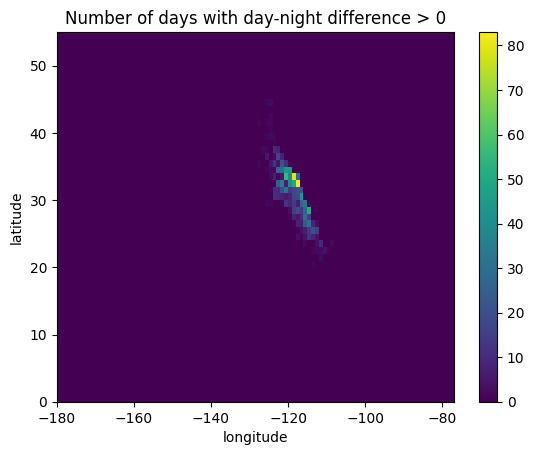

In [9]:
((xr.where(new_data.day.notnull() & new_data.night.notnull(), new_data.day - new_data.night, np.nan)) > 0).sum(
    "time"
).plot()
plt.title("Number of days with day-night difference > 0")

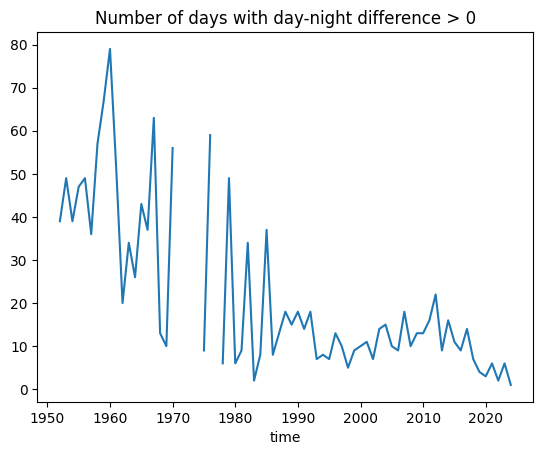

In [11]:
((xr.where(new_data.day.notnull() & new_data.night.notnull(), new_data.day - new_data.night, np.nan)) > 0).sum(
    ["latitude", "longitude"]
).resample({"time": "1YE"}).sum().plot()
plt.title("Number of days with day-night difference > 0")
plt.show()

# Remove observations when day > night


In [10]:
# to_remove = new_data["day"].where(new_data["day"] > new_data["night"]).dropna("time").time
# new_data = new_data.drop_sel(time=to_remove)
# to_remove.to_series()

## DAY


In [11]:
# data.day.dropna("time").plot(label="Original")
# new_data.day.dropna("time").plot(label="Filtered")
# plt.legend()
# plt.title("Day observations")

## NIGHT


In [12]:
# data.night.dropna("time").plot(label="Original")
# new_data.night.dropna("time").plot(label="Filtered")
# plt.legend()
# plt.title("Night observations")